# EXP 17 Segmentation map으로 도로 이미지 만들기 


* 이번시간에는 cGAN에 대해 배워보고, Pix2Pix 를 사용해 `Sketch2Pokemon` 데이터셋을 불러와, 채색을 시켜보는 작업을 해봤습니다. 


* 이번 프로젝트에선 예제의 내용을 참고해, Segnmentation map으로 도로 이미지를 만들어보는 작업을 해 보겠습니다. 

\

----

\





# 루브릭 평가 기준 
| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다. | 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다. |
| 2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다. | U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다. |
| 3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다. | 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다. |

\



-----



\

# 목차 


## 1. 데이터 및 라이브러리 불러오기 

## 2. Image augmentation 

## 3. Generator 구성하기 

## 4. "Encoder-Decoder Generator" , "U-Net Generator”로 재구성하기

## 5. Discriminator 구성하기

## 6. 학습 및 모델 테스트 

## 회고!

\



-----



\

# 1. 데이터 및 라이브러리 불러오기 


* 이번 시간에 필요한 데이터셋과 라이브러리를 불러옵니다. 
* 코랩에서 진행하는 만큼, 마운트 작업이 꼭 필요하며, 구글 드라이브에 다운받은 데이터파일을 불러오는 작업을 진행하겠습니다. 
* import 를 통해 필요한 모듈을 불러옵니다. 

\



## &nbsp;&nbsp; 1-1 라이브러리 불러오기 


* 이번시간에 쓸 라이브러리를 불러옵니다.

In [2]:
import os, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model

from tensorflow.keras import losses
from tensorflow.keras import optimizers

In [3]:
# numpy 와 텐서플로우의 버전을 확인 해봅니다. 
print(np.__version__)
print(tf.__version__)

1.21.5
2.8.0


\




## &nbsp;&nbsp; 1-2 데이터 불러오기 


* 구글 드라이브와 마운트를 하고, 드라이브 내 폴더에 있는 데이터파일 경로를 불러와주겠습니다. 

In [4]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# 해당 데이터가 있는 폴더로 이동합니다. 
os.chdir('/content/gdrive/MyDrive/AIFFEL/mkdir/conditional_generation/data')

In [6]:
# 압축 풀기! 
# !unzip -qq 'cityscapes.zip'

In [7]:
!ls

cityscapes  cityscapes.zip


* 각각의 이미지들이 어떻게 생겼는지, 학습용 데이터셋에서 임의로 6장을 선택해 확인 해 보겠습니다. 

In [8]:
data_path = '/content/gdrive/MyDrive/AIFFEL/mkdir/conditional_generation/data/cityscapes/train/'
print('train data 장 수 : ',len(os.listdir(data_path)),'장')

train data 장 수 :  1000 장


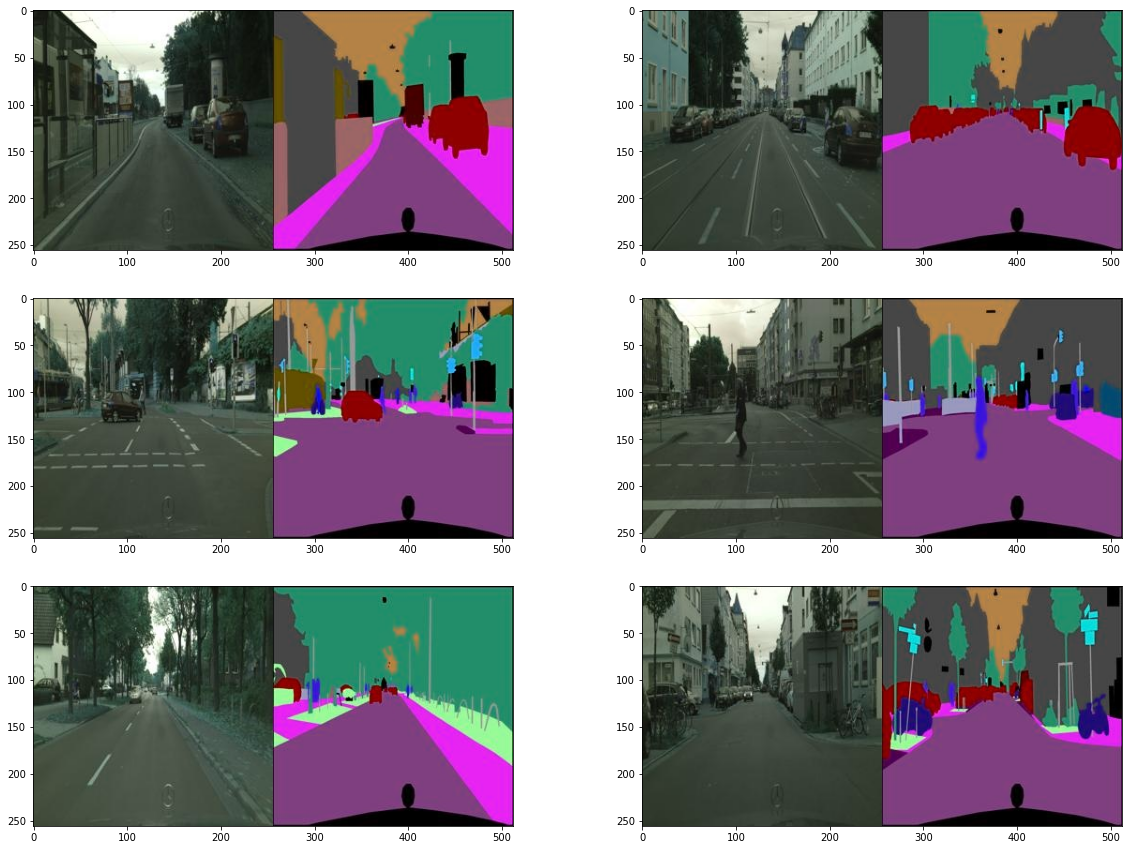

In [9]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

\\


* 원본 이미지에 학습용 이미지? 가 한쌍으로 이루어진 그림으로 구성되어있다. 
* 이미지 크기를 살펴보면, (256, 512, 3) 으로 구성되 있는걸 확인 할 수 있습니다. 
* 이미지를 2개로 분할해서 사용하면 될 것같네요. 

In [10]:
# 이미지의 크기 확인 
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


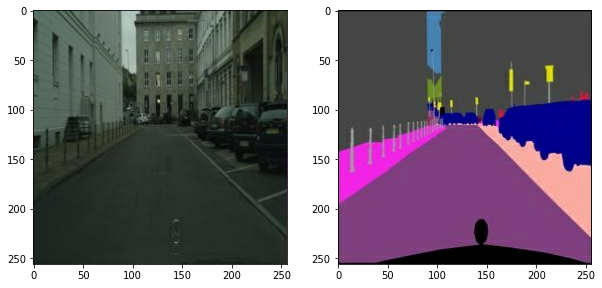

In [11]:
# 이미지를 나눠줍니다. 
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))


* 오른쪽의 이미지를 Pix2Pix 모델에 입력해서, 왼쪽과 같은 roadmap 이미지를 얻는 것이 목표가 되겠군요! 



\



----



\


# 2. Image augmentation 


* roadmap을 만드는거니깐.. 좌우 반전 정도 해 줘야할 것 같구
* 90,270도 뒤집으면 로드맵이 인셉션 영화가 되버리기 때문에, 하지 않았습니다.

In [12]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    

    out = image.random_flip_left_right(out)
    # out = image.adjust_brightness(image, 0.4)

    # out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        # out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


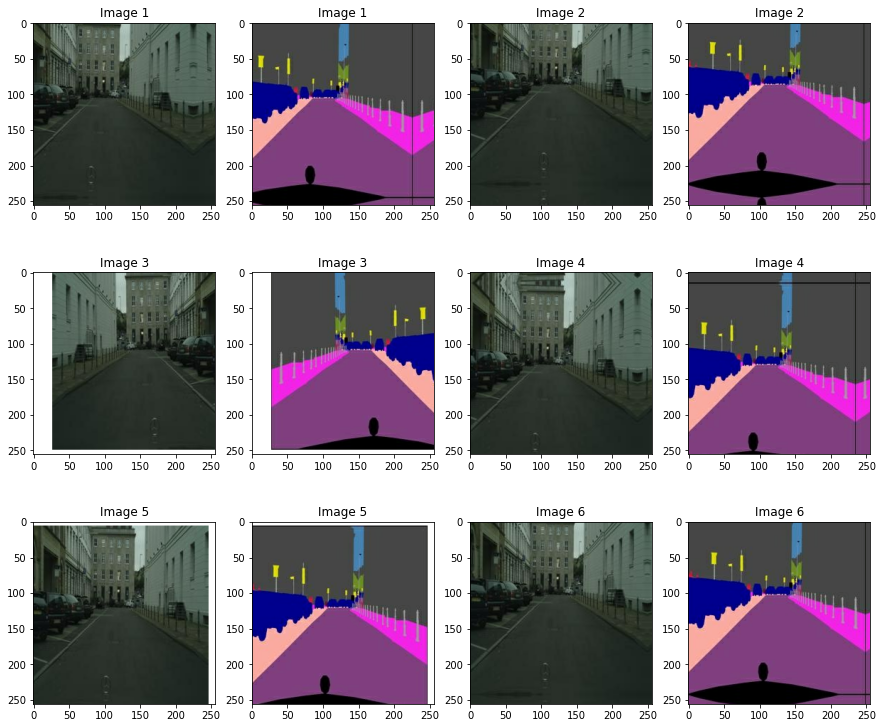

In [13]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

- 위 과정들을 학습데이터에 적용하며, 잘 적용됬는지 하나만 가져와서 시각화 해 봅니다.

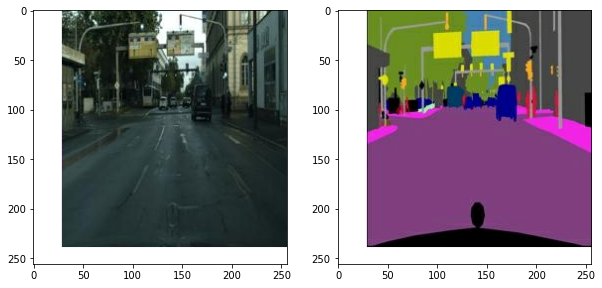

In [14]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

\



----



\


# 3. Generator 구성하기 


- Encoder를 구성하기 위한 EncodeBlock, DecodeBlock을  구현합니다.
- 구현한 EncodeBlock를 토대로 Encoder를, DecodeBlock을 토대로 Decoder를 구현합니다. 

## &nbsp;&nbsp; 3-1 EncodeBlock 구현하기.

In [15]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


\\

## &nbsp;&nbsp; 3-2 Encoder 구현하기 


- `__init__()` 메소드
    - `n_filters`, `use_bn` ⇒ 사용할 필토의 개수와 BatchNorm 사용 여부를 결정.
    - Convolution 레이어에서 **필터의 크기(=4)** 및 **stride(=2)**와 LeakyReLU 활성화의 slope coefficient(=0.2)는 **모든 곳에서 고정되어 사용하므로 각각의 값을 지정**

In [16]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


### 코드 설명!
- Encoder 클래스 블록 구성 완료! 여러번 갖다 쓰면 쉽게 Encoder를 구성할 수 있음.
- `filters` 리스트
    - 각 블록을 거치면서 사용할 필터의 개수
- `blocks`리스트
    - 사용할 블록들을 정의해 넣어둠.
- `call()` 메서드
    - 차례대로 블록들을 통과.
- 앞서 퀴즈로 알아본 것처럼 **Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않습니다.**
- `get_summary`
    - 레이어가 제대로 구성되었는지 확인하기 위한 용도

In [17]:
# get_summary 메서드를 이용해, Encoder에 (256, 256, 3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴봅니다.
Encoder().get_summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

\\

## &nbsp;&nbsp; 3-3 Decode 구현하기 

* decodeblock를 구현하고, decoder를 구현합니다.

In [18]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


- 처음 세 개의 블록에서만 Dropout을 사용하고, 마지막 convolution에는 3개의 필터를 사용해서 출력함.
- (1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인 해봅니다.

In [19]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

- (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력되었습니다.
- Encoder와 Decoder를 연결시키면 Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환되고, Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있겠군요!

\\


## &nbsp;&nbsp; 3-4 Generator 구성하기 


* tf.keras.Model을 상속받아 Encoder와 Decoder를 연결하여 구성합니다. 


In [20]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_1 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


\



----



\


# 4. "Encoder-Decoder Generator" , "U-Net Generator”로 재구성하기


* 3에서 구현한 코드는 단순히 encoder와 decoder만 연결해주었지, 다른 연결하는 부분은 없는 코드였습니다. 

* 단순한 구조 보단 U-Net으로 연결했던게 성능도 더 좋았기 때문에 U-Net을 연결해 주는 작업을 하겠습니다. 

* Encoder, Decoder 블록에서 변한건 없기 때문에, U-Net Generator를 정의 해 줍니다. 

In [21]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


### 코드 설명!
- `__init__()` 메서드
    - Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 둠
    - `encode_blocks` 및 `decode_blocks`가 `call()` 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행
- `call()`
    - forward propagation 하도록 합니다.
- `features`
    - Encoder와 Decoder 사이의 skip connection을 위해 만든 리스트
    - Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담음.
- Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데, features 리스트에 있는 각각의 출력들이 **Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됩니다.**
- call() 내에서 features = features`[:-1]`
    - Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아닙니다.
- call() 내의 Decoder 연산 부분에서 features`[::-1]`
    - Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 **대칭**을 이룹니다(맨 위 U-Net 구조 사진 참고).
    features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결합니다.

In [22]:
# U-Net 구조 Generator 내부의 각 출력이 적절한지 확인 해봅니다.

UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

- Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만 개입니다. 
- Decoder 구조 내 파라미터가 많아짐.
    - 각 convolution 레이어에서 사용된 필터의 수는 두 종류의 Decoder에서 동일하지만, 그 크기가 다릅니다.
    - 이전 Decoder 블록의 출력의 크기가 (16,16,512)라면, Encoder-decoder Generator의 경우, Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x512 입니다.
- U-Net Generator의 경우, Encoder 내 블록 출력이 함께 연결되어 Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x(512+512) 입니다.

⇒ U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, 이에 따라 **블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어났습니다.**

\



----



\


# 5. Discriminator 구성하기


* Pix2Pix를 완성시키 위해 필요한 Discriminator를 구성합니다. 
* 구성에 필요한 Block를 만들고, 출력의 크기가 맞는지 확인 해봅니다.
* DiscBlock를 가지고 Discriminator를 만듭니다.

## &nbsp;&nbsp; 5-1 DiscBlock 만들기 


* Discriminator 에 사용할 기본적인 블록을 만듭니다. 

In [23]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


- `__init__()`  에서 필요한 만큼 많은 설정을 가능하게끔 했다.
    - 필터의 수(`n_filters`)
    - 필터가 순회하는 간격(`strid`)
    - 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(`custom_pad`)
    - BatchNorm의 사용 여부(`use_bn`)
    - 활성화 함수 사용 여부(`act`)

In [24]:
# 각 출력의 크기가 맞는지 확인 해봅니다. 

inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_45 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

## &nbsp;&nbsp; 5-2 Discriminator 만들기

In [25]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


- `__init__()`
 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었습니다.
- 첫 번째 블록은 단순한 연결(`concat`)을 수행하며, 
Discriminator의 최종 출력은 `sigmoid` 활성화를 사용했습니다.

In [26]:
# 블록의 출력 크기 확인
Discriminator().get_summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

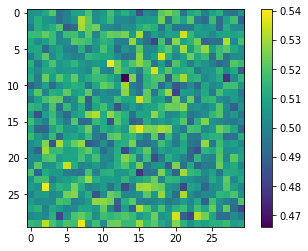

In [27]:
# (30,30) 출력 시각화 
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

- (30,30) 크기를 갖는 결과 이미지의 각 픽셀 값은 원래 입력의 (70,70) 패치에 대한 분류 결과입니다. 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있겠죠. 각각의 픽셀 값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해 내는 데 사용합니다.

\



----



\


# 6. 학습 및 모델 테스트 


- 구현된 Generator 와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해봅니다. 
- 우선, 학습에 필요한 손실함수를 정의합니다. GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 내는걸 예제에서 확인할 수 있었습니다.

## &nbsp;&nbsp; 6-1 손실함수 정의하기 

In [28]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


- Generator의 손실 함수 (위 코드의 `get_gene_loss`)는 총 3개의 입력이 있습니다. 이 중
    1. `fake_disc`는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 `tf.ones_like()`를 사용합니다. 또한 
    2. L1 손실을 계산하기 위해 생성한 가짜 이미지(`fake_output`)와 실제 이미지(`real_output`) 사이의 MAE(Mean Absolute Error)를 계산합니다.
- Discriminator의 손실 함수 (위 코드의 `get_disc_loss`)는 2개의 입력이 있습니다.
    - 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 `real_disc`는 "1"로 채워진 벡터와 비교하고, `fake_disc`는 "0"으로 채워진 벡터와 비교합니다.

## &nbsp;&nbsp; 6-2 optimizer, 가중치 정의 

In [29]:
# optimizer
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [30]:
# 가중치 1회 업데이트 
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


## &nbsp;&nbsp; 6-3 학습 진행!


* 지금까지 정의했던 함수들을 이용해 학습을 진행합니다. 
* 우선 가볍게 10epoch만 해볼까요?

In [32]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")


EPOCH[1] - STEP[100]                     
Generator_loss:1.6572                     
L1_loss:0.1620                     
Discriminator_loss:0.6697

EPOCH[1] - STEP[200]                     
Generator_loss:1.1014                     
L1_loss:0.2001                     
Discriminator_loss:0.8268

EPOCH[2] - STEP[100]                     
Generator_loss:1.8094                     
L1_loss:0.1906                     
Discriminator_loss:0.4741

EPOCH[2] - STEP[200]                     
Generator_loss:2.4740                     
L1_loss:0.1463                     
Discriminator_loss:1.4296

EPOCH[3] - STEP[100]                     
Generator_loss:0.9930                     
L1_loss:0.2222                     
Discriminator_loss:0.6817

EPOCH[3] - STEP[200]                     
Generator_loss:0.8030                     
L1_loss:0.1594                     
Discriminator_loss:1.3428

EPOCH[4] - STEP[100]                     
Generator_loss:2.5178                     
L1_loss:0.1573             

## &nbsp;&nbsp; 6-4 학습 결과 확인


* 학습해 본 모델에 Roadmap 이미지를 생성하게 해 봅니다. 


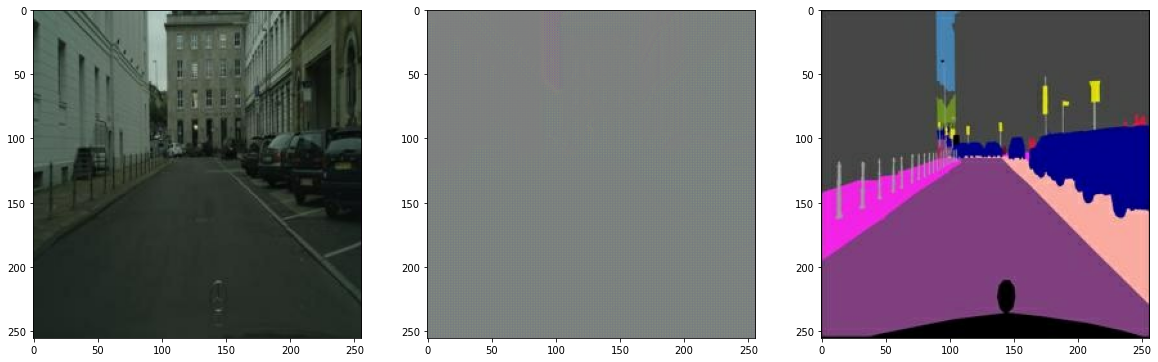

In [33]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

\



----



\


# 회고! 

### 주말안에 다 끝내려했는데 이게뭔가하니..

* 일단 10 epoch만 돌렸을 때, 원하는 결과 값을 얻지 못 했다. 도로의 결과값을 얻기는 커녕, 회색의 스모그로 뒤덮혀, 앞이 전혀 보이지 않은 행인이 보는 것과 같은 결과값이 나왔다. 당연하지.. 학습량이 적은데, 어찌 그림다운 그림을 얻을 수 있겠는가.. 


* 사실 다양한 시도.. 라기 보단 초반에 200epoch로 시작해서 500epoch 까지 해 보고싶었지만, 200epoch만 해도 반나절이 지나도록 완료도 되지 않고, 또 80epoch쯤 갔을 때, 코랩 커널이 팅겨버려, 반나절 내내 돌렸던 결과값을 모두 잃었다. checkpoint 라도 넣었더라면 헛수고하지 않았을텐데 이제와서 생각난들 무슨 소용인가.. 복습을 제대로 하지 않아 생각이 안났던 내 잘못이지.. 

* agumentation도 90도, 270도로 돌리면 도로보단 인셉션 영화의 한장면이 될 것같아 우선 180도만, 좌우대칭 처럼 돌려본 다음, 결과값을 보고 추가하거나, 밝기 조정 등을 적용해서 시도해 보고 싶었는데, 학습이..... 이렇게... 오래... 걸릴줄은..... 

* 코랩이 LMS 노드보단 빠르다고 들었던 것 같아, 익숙해 질겸 시도 해 봤던건데, 내가 뭔가 조치를 해 주지 않아서 그런건지, 아님 우리집 인터넷에 문제가있는진 모르겠지만.. 생각했던것 보다 속도도 안나오고, 완료까지 걸리는 시간이 엄청 오래 걸려서 다른 노드를 진행했을 때 보다 더 실망이 컸다. 실제로 해야하는것도 못 하고있어서 많이 우울하기도 하고.. 후.. 

* 불필요한 . 이 많긴 하지만, exp도 이번걸로 끝. 시원섭섭하기도 하고, 조금더 노력해서 좋은 결과를 얻어보는 노력도 해 봤으면 후회는 덜 되지않았을까 싶기도하구.. 

* 그래도 덕분에 드라이브에서 코랩 연결해서 가져오는 방법을 연습해 볼 수 있어서, 잘 썼다 싶기도 하다 ㅎ.. 

* 열심히하자... 

